<a href="https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/Guide_to_Quantization_and_Quantization_Aware_Training_using_the_TensorFlow_Model_Optimization_Toolkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guide to Quantization using the TensorFlow Model Optimization Toolkit

TF's model optimization Toolkit (TFMOT) contains tools that you can use to quantize and prune your model for faster inference in edge devices.

In this guide, we will see how to use TFMOT to quantize our model.

## Quantization
Quantization is where we convert the weights of our model from high precision Floats, to low precision INT8 weights.

Broadly, there are two kinds of quantization:
- **Weight quantization**: Here, the model is trained using floating point weights, but when the weights are saved, they are quantized to INT8. When performing inference, the weights are converted back to Floating point. This process results in a loss of precision of the weights which can reduce the accuracy of the model. This blog will show how to use TFMOT to do this, and how to prevent the loss in accuracy due to quantization.

- **Weight and Activation Quantization**: In weight quantization, we only quantize the weights and then upconvert the saved weights during inference. But what if we didn't need to up-convert? By quantizing both the weights and activations, you can use INT8 for inference as well.

INT8 weight quantization can reduce the size of the model by up to 4x. Moreover, if you use quantized weights and activations for inference, you can reduce your inference time as well.

You can use TFMOT to quantize your model in two ways: Quantization Aware Training and Post Training Quantization using TFLite.

In post training quantization (PTQ), we quantize the weights to 8 bits after the model has already been trained.

On the other hand, quantization aware training (QAT), emulates quantized weights during the training process. This helps the network be finetuned such that the accuracy drop is lower after quantization.

In this blog, we will explore weight quantization using both QAT and PTQ. The objective of this blog, is to compare the performance of the different quantization techniques by filling up this table:

| Model                            | Accuracy | Size |
|----------------------------------|:--------:|:----:|
| Unquantized Model                |          |      |
| Quantization Aware Model         |          |      |
| Post Training Quantization Model |          |      |


Let's get started!

## Setup and Installation

First, we will need to install some packages. We will uninstall `tensorflow` and `tensorflow-gpu`. Instead, we will use the nightly version of TensorFlow ([issue](https://github.com/tensorflow/model-optimization/issues/368)). We also need to install the TFMOT package.

In [ ]:
!pip uninstall -q -y tensorflow tensorflow-gpu
!pip install -q tf-nightly
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 521.9MB 36kB/s 
     |████████████████████████████████| 460kB 46.1MB/s 
     |████████████████████████████████| 3.0MB 60.2MB/s 
     |████████████████████████████████| 174kB 7.8MB/s 
     |████████████████████████████████| 296kB 15.7MB/s 


Next we need to import the packages we need.

We will use the MobileNetV2 model in this example, so we need to import that.

We will also fetch a dataset from `tensorflow_datasets` to train our model. Finally, we will use `matplotlib` for plotting and `numpy` for handling arrays.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import tensorflow_model_optimization as tfmot
from tensorflow import keras
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import time

## Data Collection and Preprocessing
We will use the [`deep_weeds`](https://www.tensorflow.org/datasets/catalog/deep_weeds) dataset available from `tfds`. The dataset contains 17,509 images of eight different weed species and a background class.

We will split the dataset in the ratio 8:1:1 for training, validation and testing sets. Below you can see the number of samples in each set.

In [ ]:
train_data, validation_data, test_data=tfds.load("deep_weeds",
                                                 split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
                                                 as_supervised=True)

print("Number of Training Samples:", int(tf.data.experimental.cardinality(train_data)))
print("Number of Validation Samples:", int(tf.data.experimental.cardinality(validation_data)))
print("Number of Testing Samples:", int(tf.data.experimental.cardinality(test_data)))

Number of Training Samples: 14007
Number of Validation Samples: 1751
Number of Testing Samples: 1751


Let's plot some of the images from the training set.

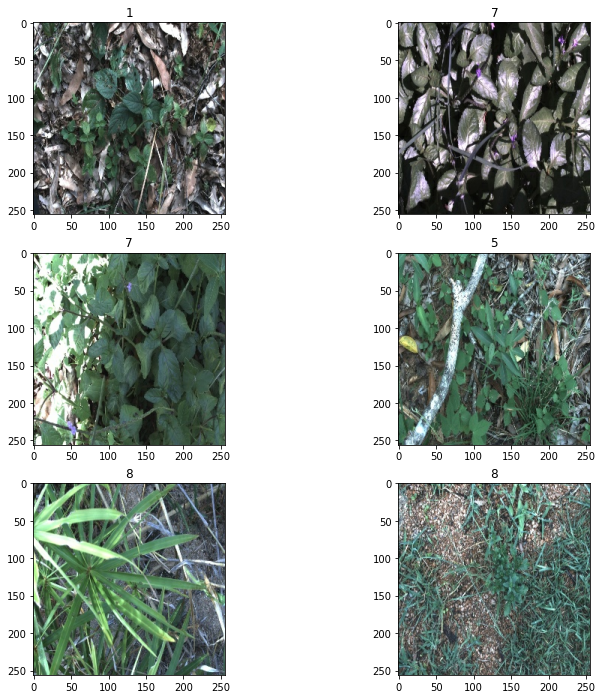

In [ ]:
plt.figure(figsize=(12,12))
for i, (image, label) in enumerate(train_data.take(6)):
    plt.subplot(3, 2, i+1)
    plt.imshow(image)
    plt.title(int(label))


Next we need to create a preprocessing function to preprocess our images. The preprocessing function is quite simple. It first converts the pixel values to float32. It then resizes the images to the shape that the MobileNetV2 model needs for input: (224, 224). Finally, it normalizes the image by dividing by 255.

We also create batches of 32 of all our sets. This will help us when training later on.

In [ ]:
def preprocessing(image, label):
    image = tf.cast(image, tf.float32)
    image=tf.image.resize(image, (224, 224))
    image=image/225.
    return image, label

train_data=train_data.map(preprocessing).shuffle(1024).batch(32)
validation_data=validation_data.map(preprocessing).shuffle(1024).batch(32)
test_data=test_data.map(preprocessing).shuffle(1024).batch(32)

## Model Creation and Training

The function in the cell below creates a model.

We will use a Global Average Pooling layer after the MobileNet output. This will be followed by two fully connected layers and an output layer with 9 neurons and a softmax activation function.

In [ ]:
def create_model(fine_tune=True):
    base_model=MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    base_model.trainable=fine_tune

    x=keras.layers.GlobalAveragePooling2D()(base_model.output)
    x=keras.layers.Dense(128, activation=tf.nn.relu)(x)
    x=keras.layers.Dense(128, activation=tf.nn.relu)(x)
    x=keras.layers.Dense(9, activation=tf.nn.softmax)(x)

    model=keras.Model(inputs=base_model.input, outputs=x)

    return model

We will use transfer learning to train the model, so we freeze the layers of the base model. We also use Early Stopping to monitor the validation loss.

In [ ]:
# Train the digit classification model
model=create_model(fine_tune=False)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callback=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', restore_best_weights=True)

model.fit(train_data, validation_data=validation_data, epochs=20, callbacks=[callback])

print("Testing Accuracy:", model.evaluate(test_data)[1])

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/20
438/438 [==============================] - 38s 87ms/step - loss: 0.7884 - accuracy: 0.7239 - val_loss: 0.6403 - val_accuracy: 0.7733
Epoch 2/20
438/438 [==============================] - 37s 84ms/step - loss: 0.5103 - accuracy: 0.8194 - val_loss: 0.5905 - val_accuracy: 0.7944
Epoch 3/20
438/438 [==============================] - 37s 84ms/step - loss: 0.4093 - accuracy: 0.8596 - val_loss: 0.5043 - val_accuracy: 0.8235
Epoch 4/20
438/438 [==============================] - 36s 82ms/step - loss: 0.3413 - accuracy: 0.8783 - val_loss: 0.5372 - val_accuracy: 0.8218
Epoch 5/20
55/55 [==============================] - 3s 49ms/step - loss: 0.5469 - accuracy: 0.8121
Testing Accuracy: 0.8121073842048645


We got a testing accuracy of 81.09%. So let's fill that in our table

| Model Name | Model Type                       | Accuracy | Size |
|------------|----------------------------------|:--------:|:----:|
| `model`    | Unquantized Model                |  81.27%  |      |
|            | Quantization Aware Model         |          |      |
|            | Post Training Quantization Model |          |      |

## Quantization Aware Training

QAT works by emulating the quantization losses that happen after quantizing the model in the training process. This means that the model will be aware of the losses that happen after quantization and it will learn to overcome them.

More specifically, each layer in the model, is changed to their quantization aware equivalent operation. It looks something like this:

| ![quantized convolution](https://github.com/sci-eco/model-optimization/raw/master/resources/quant_train.png) |
|------------|
|     [source](https://blog.tensorflow.org/2020/04/quantization-aware-training-with-tensorflow-model-optimization-toolkit.html)     |

The original weights that are backpropagated during the training process are quantized and then used to initialise the weights in the conv layer. It is these weights that are used for the forward pass during the training process. This way, the model is trained on the quantized weights. This helps to improve accuracy.

Creating a model that uses quantization aware training is as simple as calling the `tfmot.quantization.keras.quantize_model()` function on your Keras model.

You can either train a model from scratch using QAT, or you can finetune an already trainined model. In my experience, I have seen that finetuning an already trained model gives better performance, so that is what I did.

Furthermore, the training is better if you use a smaller learning rate. I have set it to `1e-4` in this case.

The rest of the model compiling and fitting logic remains the same

In [ ]:
quantization_aware_model_finetune=tfmot.quantization.keras.quantize_model(model)

quantization_aware_model_finetune.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callback=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', restore_best_weights=True)
quantization_aware_model_finetune.fit(train_data, validation_data=validation_data, epochs=20, callbacks=[callback])

print("Testing Accuracy:", quantization_aware_model_finetune.evaluate(test_data)[1])

Epoch 1/20
438/438 [==============================] - 185s 423ms/step - loss: 1.1563 - accuracy: 0.6048 - val_loss: 0.8373 - val_accuracy: 0.6962
Epoch 2/20
438/438 [==============================] - 182s 416ms/step - loss: 0.6356 - accuracy: 0.7759 - val_loss: 0.6152 - val_accuracy: 0.7990
Epoch 3/20
438/438 [==============================] - 183s 417ms/step - loss: 0.4533 - accuracy: 0.8474 - val_loss: 0.4283 - val_accuracy: 0.8629
Epoch 4/20
438/438 [==============================] - 184s 419ms/step - loss: 0.3611 - accuracy: 0.8786 - val_loss: 0.3407 - val_accuracy: 0.8852
Epoch 5/20
438/438 [==============================] - 184s 420ms/step - loss: 0.2791 - accuracy: 0.9057 - val_loss: 0.3457 - val_accuracy: 0.8806
Epoch 6/20
438/438 [==============================] - 183s 418ms/step - loss: 0.2368 - accuracy: 0.9181 - val_loss: 0.3090 - val_accuracy: 0.9018
Epoch 7/20
438/438 [==============================] - 183s 418ms/step - loss: 0.1954 - accuracy: 0.9347 - val_loss: 0.3362 -

| Model Name                          | Model Type                         | Accuracy | Size |
|-------------------------------------|------------------------------------|:--------:|:----:|
| `model`                             | Unquantized Model                  |  81.27%  |      |
| `quantization_aware_model_finetune` | Finetuned Quantization Aware Model |  90.97%  |      |
|                                     | Post Training Quantization Model   |          |      |

Training with QAT helped to increase the accuracy of the network. But why does this happen? There are a few potential reasons for it:
- Finetuning: Since we convert a previously trained model, we are in-effect, continuing the training of previously trained model. This can be a reason for the increase in accuracy.
- Regularization: Each operation in the model is now converted to its equivalent fake quantization operation. This could act like a regularization method and help improve the accuracy of the network.

**Note**: We have not tested these reasons and there could be other causes.

Previously, we finetuned the model, and while that is the preferend way to use QAT, it is not necessary to do that. In the cell below we train a model from scratch. We will refer to this model as `quantization_aware_model_no_finetune`.

In [ ]:
quantization_aware_model_no_finetune=tfmot.quantization.keras.quantize_model(create_model(fine_tune=False))

quantization_aware_model_no_finetune.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callback=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', restore_best_weights=True)
quantization_aware_model_no_finetune.fit(train_data, validation_data=validation_data, epochs=20, callbacks=[callback])

print("Testing Accuracy:", quantization_aware_model_no_finetune.evaluate(test_data)[1])

Epoch 1/20
438/438 [==============================] - 185s 422ms/step - loss: 1.1272 - accuracy: 0.6096 - val_loss: 0.7365 - val_accuracy: 0.7430
Epoch 2/20
438/438 [==============================] - 183s 418ms/step - loss: 0.6190 - accuracy: 0.7880 - val_loss: 0.4398 - val_accuracy: 0.8521
Epoch 3/20
438/438 [==============================] - 184s 420ms/step - loss: 0.4321 - accuracy: 0.8543 - val_loss: 0.3619 - val_accuracy: 0.8778
Epoch 4/20
438/438 [==============================] - 183s 418ms/step - loss: 0.3188 - accuracy: 0.8913 - val_loss: 0.4255 - val_accuracy: 0.8578
Epoch 5/20
438/438 [==============================] - 183s 419ms/step - loss: 0.2630 - accuracy: 0.9123 - val_loss: 0.3293 - val_accuracy: 0.8903
Epoch 6/20
438/438 [==============================] - 184s 421ms/step - loss: 0.2198 - accuracy: 0.9230 - val_loss: 0.2457 - val_accuracy: 0.9218
Epoch 7/20
438/438 [==============================] - 184s 419ms/step - loss: 0.1901 - accuracy: 0.9384 - val_loss: 0.2917 -




| Model Name                           | Model Type                         | Accuracy | Size |
|--------------------------------------|------------------------------------|:--------:|:----:|
| `model`                              | Unquantized Model                  |  81.28%  |      |
| `quantization_aware_model_finetune`  | Finetuned Quantization Aware Model |  90.97%  |      |
| quantization_aware_model_no_finetune | QAT Model Trained from Scratch     | 91.54%   |      |
|                                      | Post Training Quantization Model   |          |      |

Remember that all QAT is doing is changing the layers of the model. How the model is trained remains the same. By printing the model summary, you can see that all layers have been changed to their quantized versions.

In [ ]:
print(quantization_aware_model_finetune.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3           input_1[0][0]                    
__________________________________________________________________________________________________
quant_Conv1_pad (QuantizeWrappe (None, 225, 225, 3)  1           quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_Conv1 (QuantizeWrapper)   (None, 112, 112, 32) 929         quant_Conv1_pad[0][0]            
______________________________________________________________________________________________

## Quantization Inference

So far, our model is still using Floating Point weights. To quantize them to INT8, we need to convert it to TFLite format.

We can use the below code to do that. Setting the `converter.optimization` to `tf.lite.Optimize.DEFAULT` is what converts the weight to INT8. If you do not specify that line, then the model will be converted to TFLite format, but it will still use Floating Point weights.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quantization_aware_model_finetune)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantization_aware_tflite_model_finetune = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/tmphrg7qvk3/assets


INFO:tensorflow:Assets written to: /tmp/tmphrg7qvk3/assets


We can use the same steps to quantize the model that we trained from scratch.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quantization_aware_model_no_finetune)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantization_aware_tflite_model_no_finetune = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp4qbncqsm/assets


INFO:tensorflow:Assets written to: /tmp/tmp4qbncqsm/assets


To perform inference using TFLite, we can use the helper function below. Using TFLite, the we can run inference only one at a time. So running this will take some time.

The function was adapted from [here](https://www.tensorflow.org/model_optimization/guide/quantization/training_example).

In [ ]:
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    accuracy=0
    count=0
    inference_time=0
    for image_batch, label_batch in test_data:
        for image, label in zip(image_batch, label_batch):
            image = np.expand_dims(image, axis=0).astype(np.float32)

            start=time.time()
            interpreter.set_tensor(input_index, image)

            interpreter.invoke()

            output = interpreter.tensor(output_index)
            inference_time+=time.time()-start

            predicted_label = np.argmax(output()[0])
            if predicted_label == label:
                accuracy+=1
            count+=1

    return accuracy/count, inference_time/count

Below, we can check the accuracy of the model after converting to TFLite with INT8 weights.

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantization_aware_tflite_model_finetune)
interpreter.allocate_tensors()

test_accuracy, inference_time = evaluate_model(interpreter)

print(f'Test accuracy: {test_accuracy*100}%' )
print(f'Average Inference Time per sample {inference_time} sec')

Test accuracy: 90.97658480868076%
Average Inference Time per sample 0.930652964530435 sec


I have added another column to the table which specifies the weight type. Remember that the weigths in the TFLite model are stored using INT8 and then converted to Float32 during inference.

| Model Name                                 | Model Type                           | Accuracy | Size | Weight Precision |
|--------------------------------------------|--------------------------------------|:--------:|:----:|------------------|
| `model`                                    | Unquantized Model                    |  81.27%  |      | FLOAT32          |
| `quantization_aware_model_finetune`        | Finetuned Quantization Aware Model   |  90.97%  |      | FLOAT32          |
| `quantization_aware_model_no_finetune`     | QAT Model Trained from Scratch       | 91.54%   |      | FLOAT32          |
| `quantization_aware_tflite_model_finetune` | Finetuned QAT model TFLite Quantized | 90.97%  |      | INT8             |
|                                            | Post Training Quantization Model     |          |      |                  |

In [ ]:
interpreter = tf.lite.Interpreter(model_content=quantization_aware_tflite_model_no_finetune)
interpreter.allocate_tensors()

test_accuracy, inference_time = evaluate_model(interpreter)

print(f'Test accuracy: {test_accuracy*100}%' )
print(f'Average Inference Time per sample {inference_time} sec')

Test accuracy: 91.71901770416905%
Average Inference Time per sample 0.9346779042281538 sec


As you can see, there is very litle drop in accuracy from the quantized model and the actual model. This is because the model knew the quantization loss that would happen and learned to work around that loss.


| Model Name                                    | Model Type                            | Accuracy | Size | Weight Precision |
|-----------------------------------------------|---------------------------------------|:--------:|:----:|------------------|
| `model`                                       | Unquantized Model                     |  81.27%  |      | FLOAT32          |
| `quantization_aware_model_finetune`           | Finetuned Quantization Aware Model    |  90.97%  |      | FLOAT32          |
| `quantization_aware_model_no_finetune`        | QAT Model Trained from Scratch        | 91.54%   |      | FLOAT32          |
| `quantization_aware_tflite_model_finetune`    | Finetuned QAT model; TFLite Quantized | 90..97%  |      | INT8             |
| `quantization_aware_tflite_model_no_finetune` | Scratch QAT model; TFLite Quantized   | 91.71%   |      | INT8             |
|                                               | Post Training Quantization Model      |          |      |                  |

## Post Training Quantization

In the previous section, we quantized the model that was trained using QAT.

What about the accuracy of a model that was trained without QAT? Let's quantize the first model we trained.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

normal_tflite_model_quantized = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp8pruzkuw/assets


INFO:tensorflow:Assets written to: /tmp/tmp8pruzkuw/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content=normal_tflite_model_quantized)
interpreter.allocate_tensors()

test_accuracy, inference_time = evaluate_model(interpreter)

print(f'Test accuracy: {test_accuracy*100}%' )
print(f'Average Inference Time per sample {inference_time} sec')

Test accuracy: 50.0856653340948%
Average Inference Time per sample 0.04431839768100915 sec


As you can see, the accuracy of the model without QAT is much less.

| Model Name                                    | Model Type                            | Accuracy | Size | Weight Precision |
|-----------------------------------------------|---------------------------------------|:--------:|:----:|------------------|
| `model`                                       | Unquantized Model                     |  81.27%  |      | FLOAT32          |
| `quantization_aware_model_finetune`           | Finetuned Quantization Aware Model    |  90.97%  |      | FLOAT32          |
| `quantization_aware_model_no_finetune`        | QAT Model Trained from Scratch        | 91.54%   |      | FLOAT32          |
| `quantization_aware_tflite_model_finetune`    | Finetuned QAT model; TFLite Quantized | 90.97%  |      | INT8             |
| `quantization_aware_tflite_model_no_finetune` | Scratch QAT model; TFLite Quantized   | 91.71%   |      | INT8             |
| `normal_tflite_model_quantized`               | PTQ Model without QAT                 | 50.08%  |      | INT8             |

Now, let's see the accuracy of the normal model after converting to TFLite Format. Below, we omit setting the `converter.optimization`, so the model will not be quantized when storing.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

normal_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpnjyky5cr/assets


INFO:tensorflow:Assets written to: /tmp/tmpnjyky5cr/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content=normal_tflite_model)
interpreter.allocate_tensors()

start=time.time()
test_accuracy, inference_time = evaluate_model(interpreter)

print(f'Test accuracy: {test_accuracy*100}%' )
print(f'Average Inference Time per sample {inference_time} sec')

Test accuracy: 81.21073672187322%
Average Inference Time per sample 0.02834899897986586 sec


Since this model still uses the floating point weights, there is no accuracy drop.

| Model Name                                    | Model Type                            | Accuracy | Size | Weight Precision |
|-----------------------------------------------|---------------------------------------|:--------:|:----:|------------------|
| `model`                                       | Unquantized Model                     |  81.27%  |      | FLOAT32          |
| `quantization_aware_model_finetune`           | Finetuned Quantization Aware Model    |  90.97%  |      | FLOAT32          |
| `quantization_aware_model_no_finetune`        | QAT Model Trained from Scratch        | 91.54%   |      | FLOAT32          |
| `quantization_aware_tflite_model_finetune`    | Finetuned QAT model; TFLite Quantized | 90.97%  |      | INT8             |
| `quantization_aware_tflite_model_no_finetune` | Scratch QAT model; TFLite Quantized   | 91.71%   |      | INT8             |
| `normal_tflite_model_quantized`               | PTQ Model without QAT                 | 50.08%  |      | INT8             |
| `normal_tflite_model`                         | TFLite Model without Quantization     | 81.21%    |      | FLOAT32          |

## Saving Models and More PTQ

Let's save the models we trained and compare the file sizes.

We will first save the model with keras's `h5` format. We will also save the TFLite model with quantization and without quantization.

In [ ]:
model.save('main_model.h5')
quantization_aware_model_finetune.save('quantization_aware_model_finetune.h5')
quantization_aware_model_no_finetune.save('quantization_aware_model_no_finetune.h5')

with open("quantization_aware_tflite_model_finetune.tflite", "wb") as f:
    f.write(quantization_aware_tflite_model_finetune)

with open("quantization_aware_tflite_model_no_finetune.tflite", "wb") as f:
    f.write(quantization_aware_tflite_model_no_finetune)

with open("normal_tflite_model.tflite", "wb") as f:
    f.write(normal_tflite_model)

!ls -lh *

-rw-r--r-- 1 root root  12M May 11 06:06 main_model.h5
-rw-r--r-- 1 root root 9.2M May 11 06:06 normal_tflite_model.tflite
-rw-r--r-- 1 root root  29M May 11 06:06 quantization_aware_model_finetune.h5
-rw-r--r-- 1 root root  29M May 11 06:06 quantization_aware_model_no_finetune.h5
-rw-r--r-- 1 root root 2.8M May 11 06:06 quantization_aware_tflite_model_finetune.tflite
-rw-r--r-- 1 root root 2.8M May 11 06:06 quantization_aware_tflite_model_no_finetune.tflite

sample_data:
total 55M
-rwxr-xr-x 1 root root 1.7K Jan  1  2000 anscombe.json
-rw-r--r-- 1 root root 295K May  4 16:26 california_housing_test.csv
-rw-r--r-- 1 root root 1.7M May  4 16:26 california_housing_train.csv
-rw-r--r-- 1 root root  18M May  4 16:26 mnist_test.csv
-rw-r--r-- 1 root root  35M May  4 16:26 mnist_train_small.csv
-rwxr-xr-x 1 root root  930 Jan  1  2000 README.md


The 'h5' model takes the most space. On the other hand, the quantized models takes up about 3.3x lesser space than the space of the normal TFLite model. Remember that the reduction is due to weights being stored in lower precision.

| Model Name                                    | Model Type                            | Accuracy | Size | Weight Precision |
|-----------------------------------------------|---------------------------------------|:--------:|:----:|------------------|
| `model`                                       | Unquantized Model                     |  81.27%  |  12M | FLOAT32          |
| `quantization_aware_model_finetune`           | Finetuned Quantization Aware Model    |  90.97%  |  29M | FLOAT32          |
| `quantization_aware_model_no_finetune`        | QAT Model Trained from Scratch        | 91.54%   | 29M  | FLOAT32          |
| `quantization_aware_tflite_model_finetune`    | Finetuned QAT model; TFLite Quantized | 90.97%  | 2.8M | INT8             |
| `quantization_aware_tflite_model_no_finetune` | Scratch QAT model; TFLite Quantized   | 91.71%   | 2.8M | INT8             |
| `normal_tflite_model_quantized`               | PTQ Model without QAT                 | 50.08%  | 2.8M | INT8             |
| `normal_tflite_model`                         | TFLite Model without Quantization     | 81.21%    | 9.2M | FLOAT32          |

If you want to load a model that was trained using QAT, you can do so by using `quantize_scope()`

In [ ]:
with tfmot.quantization.keras.quantize_scope():
  loaded_model = tf.keras.models.load_model('quantization_aware_model_finetune.h5')

## Some other PTQ

So far we have been using only the `DEFAULT` optimization method. TFLite also provides two other optimization schemes: OPTIMIZE_FOR_LATENCY and OPTIMIZE_FOR_SIZE.

Let's see the results when optimizing for size

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_size_optimized_quant_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_size_optimized_quant_model)
interpreter.allocate_tensors()

start=time.time()
test_accuracy, inference_time = evaluate_model(interpreter)

print(f'Test accuracy: {test_accuracy*100}%' )
print(f'Average Inference Time per sample {inference_time} sec')

with open("tflite_size_optimized_quant_model.tflite", "wb") as f:
    f.write(tflite_size_optimized_quant_model)

!ls -lh tflite_size_optimized_quant_model.tflite

INFO:tensorflow:Assets written to: /tmp/tmpe0rkxf6m/assets


INFO:tensorflow:Assets written to: /tmp/tmpe0rkxf6m/assets


Test accuracy: 90.97658480868076%
Average Inference Time per sample 0.9295434151153303 sec
-rw-r--r-- 1 root root 2.8M May 11 06:34 tflite_size_optimized_quant_model.tflite


Now let's see the results when optimize for latency.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
tflite_latency_optimized_quant_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_latency_optimized_quant_model)
interpreter.allocate_tensors()

test_accuracy, inference_time = evaluate_model(interpreter)

print(f'Test accuracy: {test_accuracy*100}%' )
print(f'Average Inference Time per sample {inference_time} sec')

with open("tflite_latency_optimized_quant_model.tflite", "wb") as f:
    f.write(tflite_latency_optimized_quant_model)

!ls -lh tflite_latency_optimized_quant_model.tflite

INFO:tensorflow:Assets written to: /tmp/tmpuil2g1zv/assets


INFO:tensorflow:Assets written to: /tmp/tmpuil2g1zv/assets


Test accuracy: 90.97658480868076%
Average Inference Time per sample 0.9212308236355784 sec
-rw-r--r-- 1 root root 2.8M May 11 07:01 tflite_latency_optimized_quant_model.tflite


So when using the `OPTIMIZE_FOR_SIZE` scheme, we don't see any changes in results. However, when using the `OPTIMIZE_FOR_LATENCY` scheme, the inference is slightly faster and there is no drop in accuracy.

## Conclusion

In this blog, we used the TensorFlow Model Optimization Toolkit to train our models with Quantization Aware training. Doing so helps to reduce the accuracy drop when we quantize our model for deployment. Our final results, look like this:

| Model Name                                    | Model Type                            | Accuracy | Size | Weight Precision | Quantization Type    |
|-----------------------------------------------|---------------------------------------|:--------:|:----:|------------------|----------------------|
| `model`                                       | Unquantized Model                     |  81.27%  |  12M | FLOAT32          | N/A                  |
| `quantization_aware_model_finetune`           | Finetuned Quantization Aware Model    |  90.97%  |  29M | FLOAT32          | QAT                  |
| `quantization_aware_model_no_finetune`        | QAT Model Trained from Scratch        | 91.54%   | 29M  | FLOAT32          | QAT                  |
| `quantization_aware_tflite_model_finetune`    | Finetuned QAT model; TFLite Quantized | 90.97%   | 2.8M | INT8             | DEFAULT              |
| `quantization_aware_tflite_model_no_finetune` | Scratch QAT model; TFLite Quantized   | 91.71%   | 2.8M | INT8             | DEFAULT              |
| `normal_tflite_model_quantized`               | PTQ Model without QAT                 | 50.08%   | 2.8M | INT8             | DEFAULT              |
| `normal_tflite_model`                         | TFLite Model without Quantization     | 81.21%   | 9.2M | FLOAT32          | N/A                  |
| `tflite_size_optimized_quant_model`           | TFLite Model Optimized for Size       | 90.97%   | 2.8M | INT8             | OPTIMIZE_FOR_SIZE    |
| `tflite_latency_optimized_quant_model`        | TFLite Model Optimized for Latency    | 90.97%   | 2.8M | INT8             | OPTIMIZE_FOR_LATENCY |

From the table we can see that models trained with QAT have very little to no loss in accuracy after being quantized. On the other hand, the accuracy of a non-QAT model drops by more than 30%!

Another observation we made was that quantized models are more than 3 times smaller than their unquantized counterparts. This is helpful when you want to deploy your model to memory constrained edge devices.

However, one thing that we did not talk about in this blog is the inference latency of our models, i.e., the time it takes to run inference. Another thing we did not talk about was how to perform post training INT8 weights and activation quantization. By doing this, we can use full INT8 during inference. We will see how to do this and measure the inference time for all the models in the next blog!